In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, '/scratch/fivanovic/Work/X-SH/eigenstate_plotting')
import XSH_eigenstates_Filip as XSF

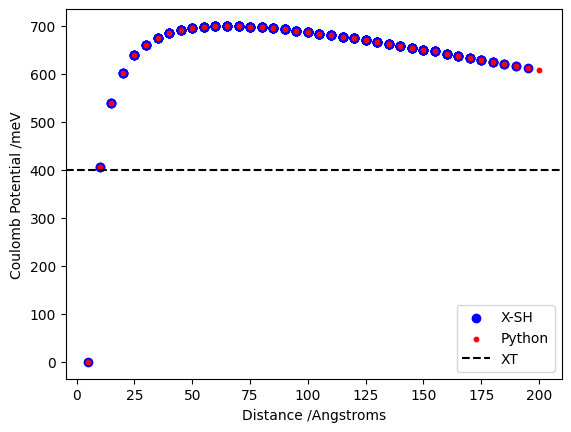

In [2]:
#checking that the X-SH coulomb barrier generated using build_barrier_recursive is the same as the python epsilon=3.5 barrier. It's not,
#because the iCT distance in X-SH is 10 ang, so the reference energy is 2x as large compared to python, so the coulomb barrier is actually small,
#and entirely below the XT energy.

coulomb_barrier = np.loadtxt('/scratch/fivanovic/X-SH/T6-PDI/testing_debugging/check_coulomb_barrier/READIN_e3p5_DIAGONALS.include')
coulomb_barrier = coulomb_barrier[:,2]*27.211396641308*1000

XT_CT_offset = 400

distances = np.loadtxt('/scratch/fivanovic/X-SH/T6-PDI/testing_debugging/check_coulomb_barrier/READIN_e3p5_CT_DISTANCES.include')
distances = distances[:,2]

lattice_x_distances = np.arange(1,41)
e3p5_barrier = [((-822.84/d - 1e-3*1000*5*d) - (-822.84 - 1e-3*1000*5)) for d in lattice_x_distances]
e9_barrier = [((-360/d - 1e-3*1000*5*d) - (-360 - 1e-3*1000*5)) for d in lattice_x_distances]
#It is, however, quite similar to the epsilon=10 barrier, so we can still use the sim to explore what happens when the barrier is low.

plt.scatter(distances, coulomb_barrier - np.min(coulomb_barrier), color = 'b', label = 'X-SH')
plt.scatter((lattice_x_distances)*5, e3p5_barrier, color = 'r', s = 10, label = 'Python')
plt.axhline(min(e3p5_barrier) + XT_CT_offset, color = 'k', linestyle = '--', label = 'XT')
plt.xlabel('Distance /Angstroms')
plt.ylabel('Coulomb Potential /meV')
plt.legend()

In [3]:
def switch_coulomb_1D(input_barrier, input_distances, number_acceptors, start, end):
    #function for switching around chunks of the coulomb barrier in a 1D chain, as sometimes an increase in DECOMP index actually corresponds to a molecule
    #being further from the interface

    #input barrier and distances are input lists of coulomb potentials and corresponding e-h distances in the order shown below

    #start = list index where you want to start iterating, end = index where you want to stop

    coulomb_barrier_for_sim = input_barrier[:]
    x_distances_for_sim = input_distances[:]

    for counter in range(start, end, 2*number_acceptors): #indexing in Hamiltonian goes: donor + all acceptors --> next donor + all acceptors etc. Each vertical 6T chain 
        #, DECOMP index increases from left to right, so I swap every N_acc elements in coulomb barrier list to follow this index

        first_donor_coulomb, second_donor_coulomb = input_barrier[counter: counter + number_acceptors], input_barrier[counter + number_acceptors: counter + 2*number_acceptors]
        first_donor_distances, second_donor_distances = input_distances[counter: counter + number_acceptors], input_distances[counter + number_acceptors: counter + 2*number_acceptors]

        coulomb_barrier_for_sim[counter: counter + number_acceptors] = second_donor_coulomb
        coulomb_barrier_for_sim[counter + number_acceptors: counter + 2*number_acceptors] = first_donor_coulomb

        x_distances_for_sim[counter : counter + number_acceptors] = second_donor_distances
        x_distances_for_sim[counter + number_acceptors: counter + 2*number_acceptors] = first_donor_distances

    return coulomb_barrier_for_sim, x_distances_for_sim

In [4]:
def switch_coulomb_2D(input_barrier, input_distances, donors_yaxis, number_acceptors, start, end):

    coulomb_barrier_for_sim = input_barrier[:]
    distances_for_sim = input_distances[:]

    for counter in range(start, end, 2*donors_yaxis*number_acceptors):

        first_donor_coulomb = input_barrier[counter : counter + donors_yaxis*number_acceptors]
        second_donor_coulomb = input_barrier[counter + donors_yaxis*number_acceptors : counter + donors_yaxis*2*number_acceptors]

        first_donor_distances = input_distances[counter : counter + donors_yaxis*number_acceptors]
        second_donor_distances = input_distances[counter + donors_yaxis*number_acceptors : counter + donors_yaxis*2*number_acceptors]

        combined_coulomb = []
        combined_distances = []
        
        for counter2 in range(0, donors_yaxis):

            combined_coulomb = combined_coulomb + second_donor_coulomb[counter2*number_acceptors: counter2*number_acceptors + number_acceptors]
            combined_coulomb = combined_coulomb + first_donor_coulomb[counter2*number_acceptors: counter2*number_acceptors + number_acceptors]

            combined_distances = combined_distances + second_donor_distances[counter2*number_acceptors: counter2*number_acceptors + number_acceptors]
            combined_distances = combined_distances + first_donor_distances[counter2*number_acceptors: counter2*number_acceptors + number_acceptors]

        coulomb_barrier_for_sim[counter : counter + donors_yaxis*2*number_acceptors] = combined_coulomb
        distances_for_sim[counter : counter + donors_yaxis*2*number_acceptors] = combined_distances

    return coulomb_barrier_for_sim, distances_for_sim

In [5]:
vecs = XSF.build_lattice(40,1,5)
vecs = np.delete(vecs,21,axis=0) #deleting vec corresponding to PDI 306 for defect Coulomb barrier
dons, accs = XSF.DA_index(vecs, 20)
nearest_neighbours = XSF.build_connectivity(vecs, 5)

CT_states = XSF.define_CT_states_twophase(dons, accs)
XT_states = XSF.define_XT_states(accs)

H_CT_e3 = XSF.build_CT_block(CT_states, vecs, nearest_neighbours, -822.84, 45.8, 20.7, -1e-3)

H_XT = XSF.build_XT_block(XT_states, nearest_neighbours, 390.1, 85.7)
H_XT_CT = XSF.build_XT_CT_block(XT_states, CT_states, nearest_neighbours, 61.8)

H = XSF.build_full_Hamiltonian(H_CT_e3, H_XT, H_XT_CT)

x_distances, y_distances = XSF.get_CT_distances(CT_states, vecs)

coulomb_barrier_for_sim = [((-576/d - 1e-3*1000*5*d) - (-576 - 1e-3*1000*5)) for d in np.array(x_distances)/5]
number_acceptors = 19
    
coulomb_barrier_for_sim, x_distances_for_sim = switch_coulomb_1D(coulomb_barrier_for_sim, x_distances, 19, 0, 380)

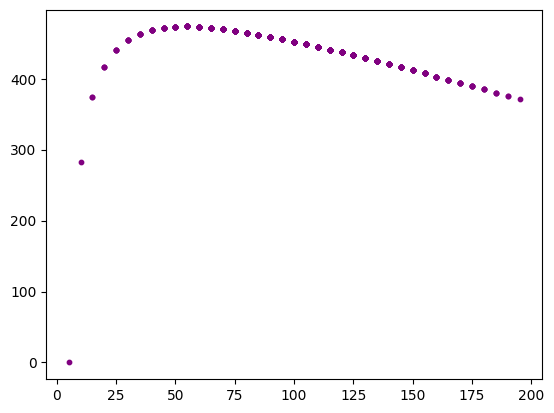

In [6]:
#euclidean_distances = [np.sqrt(y_distances[j]**2 + x_distances[j]**2) for j in range(len(x_distances))]
#coulomb_barrier_for_sim = [((-579.6/d - 1e-3*1000*5*d) - (-579.6 - 1e-3*1000*5)) for d in np.array(euclidean_distances)/5]

#coulomb_barrier_for_sim, euclidean_distances = switch_coulomb_2D(coulomb_barrier_for_sim, euclidean_distances, 5, 50, 250, 1250)
#switching coulomb barrier and ct-distance indices around for the 6T molecules in the 2D decomp file. I plotted euclidean distance vs coulomb 
#interaction and I recover the classical relationship. Then I checked how the ct-distance varies with the ct index. First 5 6T molecules have the 
#same minimum distances as they are on the same axis. Next 10 6T molecules are in 2 different columns and indexed alternatively starting with the 
#bottom molecule of the closer column. I therefore see alternating minimum distances as I plot ct-distance vs ct index in the range, starting with 
#the lower minimum distance fist, which is consistent with the order of 6T molecules in the DECOMP file. The same thing occurs for the next 10 6T 
#molecules closer to the interface.

plt.scatter(x_distances_for_sim, coulomb_barrier_for_sim, color='purple', s=10)

In [55]:
diagonal_file = open('FRZ_DIAGONALS_COULOMB-defect.include', 'a')
distance_file = open('CT_DISTANCES-defect.include', 'a')

for index in range(len(coulomb_barrier_for_sim)):

    diagonal_file.write(f'{index+1} {index+1} {coulomb_barrier_for_sim[index]/(27.211396641308*1000)}\n')
    distance_file.write(f'{index+1} {index+1} {x_distances_for_sim[index]}\n')

diagonal_file.close()
distance_file.close()

In [14]:
#can calculate x-distances between molecules specified in decomp file, and check if the CT-states' distances follow the pattern that the python scipt
#does. This is crucial, as I am passing in the python site energies into the X-SH Hamiltonian, so the indices of the CT-states must be the same.

readin_ct_xdistances = np.loadtxt('/scratch/fivanovic/X-SH/T6-PDI/testing_debugging/check_coulomb_barrier/READIN_CT_xDISTANCES.include')
readin_ct_xdistances = readin_ct_xdistances[:,2]*1e10

(340.0, 380.0)

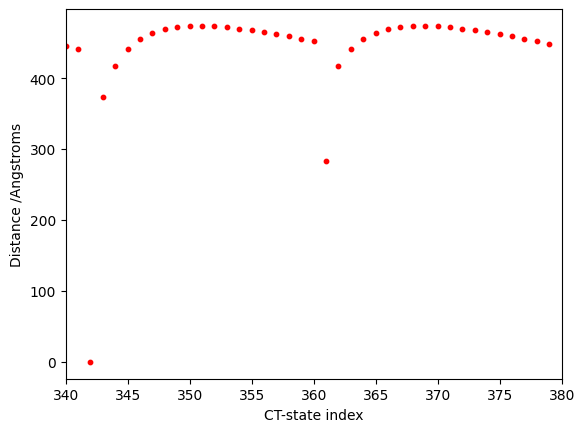

In [18]:
plt.scatter(np.arange(len(coulomb_barrier_for_sim)), coulomb_barrier_for_sim, color = 'r', s = 10)
plt.ylabel('Distance /Angstroms')
plt.xlabel('CT-state index')
plt.xlim([340,380])